In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import seaborn as sns
from matplotlib.colors import ListedColormap

my_cmap = ListedColormap(sns.light_palette((210, 90, 60), input="husl", n_colors=50))
my_cmap = ListedColormap(sns.diverging_palette(220, 20, n=50))
my_cmap = ListedColormap(sns.color_palette("RdBu_r", 50))
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

from matplotlib.colors import to_rgb, to_rgba

def scatter(x, y, color, alpha_arr, **kwarg):
    r, g, b = to_rgb(color)
    # r, g, b, _ = to_rgba(color)
    color = [(r, g, b, alpha) for alpha in alpha_arr]
    plt.scatter(x, y, c=color, **kwarg)

In [2]:
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn.functional as F

from torch import distributions
from torch import nn
from torch.nn.parameter import Parameter
from torchvision import datasets, transforms
import sys
sys.path.append('../')
from core import networks
from core import toy_data

In [4]:
device = torch.device('cpu')

In [5]:
def sample_data(name, batch_size):
    x = toy_data.inf_train_gen(name, batch_size=batch_size)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    return x

def plot_samples(samples):
    _ = plt.hist2d(samples.detach().numpy()[:,0], 
                   samples.detach().numpy()[:,1], 
                   bins=50, cmap=my_cmap)
    
@torch.no_grad()
def plot_ebm_density(ebm):
    x = torch.linspace(-3.,3.,100)
    y = torch.linspace(-3.,3.,100)
    x_grid,y_grid = torch.meshgrid(x,y)
    pdf = torch.exp(-ebm(torch.stack([x_grid, y_grid], axis=2).reshape([-1, 2])))
    pdf = pdf.numpy().reshape([100, 100])
    plt.contourf(x_grid, y_grid, pdf, levels=30, cmap=my_cmap)

In [6]:
class EBM(nn.Module):
    def __init__(self, net, base_dist=None):
        super(EBM, self).__init__()
        self.net = net
        if base_dist is not None:
            self.base_mu = nn.Parameter(base_dist.loc)
            self.base_logstd = nn.Parameter(base_dist.scale.log())
        else:
            self.base_mu = None
            self.base_logstd = None

    def forward(self, x):
        if self.base_mu is None:
            bd = 0
        else:
            base_dist = distributions.Normal(self.base_mu, self.base_logstd.exp())
            bd = base_dist.log_prob(x).view(x.size(0), -1).sum(1)
        return self.net(x) - bd
    
    def sample(self, x_init, l=1., e=.01, n_steps=200, anneal=None):
        x_k = torch.autograd.Variable(x_init, requires_grad=True)
        # sgld
        if anneal == "lin":
            lrs = list(reversed(np.linspace(e, l, n_steps)))
        elif anneal == "log":
            lrs = np.logspace(np.log10(l), np.log10(e))
        else:
            lrs = [l for _ in range(n_steps)]
        for this_lr in lrs:
            f_prime = torch.autograd.grad(self(x_k).sum(), [x_k], retain_graph=True)[0]
            x_k.data += this_lr * -f_prime + torch.randn_like(x_k) * e
        final_samples = x_k.detach()
        return final_samples

In [7]:
train_data = sample_data('8gaussians', 1000)

net = networks.SmallMLP(2)
mu, sigma = train_data.mean(0), train_data.std(0)
base_dist = distributions.Normal(mu, sigma)
ebm = EBM(net, base_dist)

# previous_ebm = deepcopy(ebm)
# particles = ebm.sample(train_data.clone(), l=0.1/2, e=np.sqrt(0.1))
# optimizer = optim.Adam(ebm.parameters(), lr=1e-4, betas=(.0, .999))

In [15]:
train_data.shape

torch.Size([1000, 2])

In [14]:
base_dist.sample((100,))

torch.Size([100, 2])

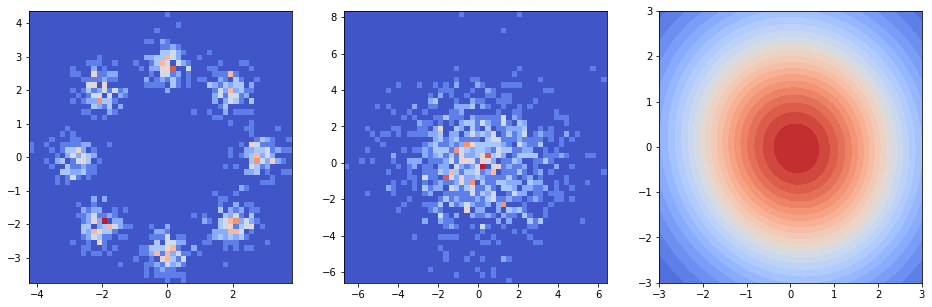

In [80]:
figsize(16,5)
plt.subplot(131)
plot_samples(train_data)
plt.subplot(132)
plot_samples(particles)
plt.subplot(133)
plot_ebm_density(ebm)

In [81]:
n_iterations = 1000
for _ in range(n_iterations):
    #update model
    loss = ebm(train_data).mean()-ebm(particles).mean()
    loss.backward()
    optimizer.step()
    #update particles
    grad_particles = torch.autograd.Variable(particles, requires_grad=True)
    diff = lambda x: previous_ebm(x) - ebm(x)
    particles += torch.autograd.grad(diff(grad_particles).sum(), [grad_particles], retain_graph=True)[0].detach()
    previous_ebm = deepcopy(ebm)

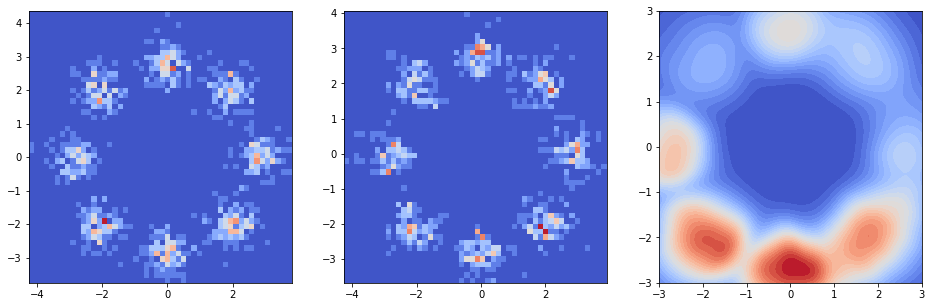

In [82]:
figsize(16,5)
plt.subplot(131)
plot_samples(train_data)
plt.subplot(132)
plot_samples(particles)
plt.subplot(133)
plot_ebm_density(ebm)

In [17]:
train_data = sample_data('8gaussians', 1000)

net = networks.SmallMLP(2)
mu, sigma = train_data.mean(0), train_data.std(0)
base_dist = distributions.Normal(mu, sigma)
ebm = EBM(net, base_dist)

previous_ebm = deepcopy(ebm)
particles = ebm.sample(train_data.clone(), l=0.1/2, e=np.sqrt(0.1))
optimizer = optim.Adam(ebm.parameters(), lr=1e-4, betas=(.0, .999))

In [84]:
n_iterations = 1000
for _ in range(n_iterations):
    #update model
    loss = ebm(train_data).mean()-ebm(particles).mean()
    loss.backward()
    optimizer.step()
    #update particles
    for _ in range(10):
        grad_particles = torch.autograd.Variable(particles, requires_grad=True)
        grad = torch.autograd.grad(ebm(grad_particles).sum(), [grad_particles], retain_graph=True)[0].detach()
        particles += -grad*0.1/2. + torch.randn_like(particles)*np.sqrt(0.1)

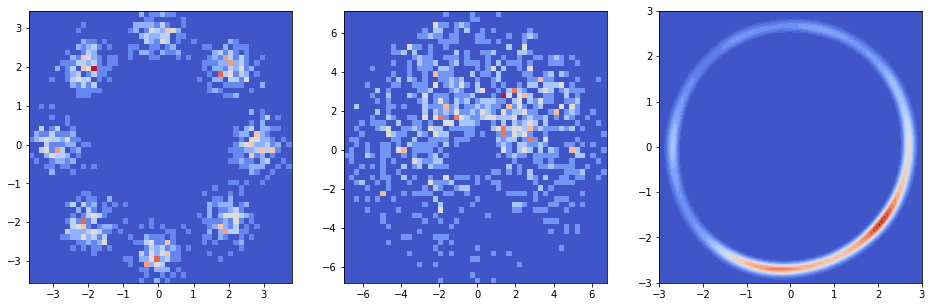

In [85]:
figsize(16,5)
plt.subplot(131)
plot_samples(train_data)
plt.subplot(132)
plot_samples(particles)
plt.subplot(133)
plot_ebm_density(ebm)

In [19]:
particles.size()

torch.Size([1000, 2])

In [21]:
mmd = MMDStatistic(len(particles), len(train_data))

In [25]:
mmd(particles, train_data, np.ones(2))

tensor(0.1072)